In [1]:
import pandas as pd
import networkx as nx
import math as math

from IPython.display import Image

# Context for Recurse

This is a script I wrote for a reseach project at Consumer Reports.

## Background Context
California consumers can request that companies send them a copy of their data. We want to test the access process by sending a request to a bunch of companies from a bunch of consumers. We recruited ~200 participants and selected a dozen companies. 

### Problem
It's usually not helpful to send requests to companies you're never been a customer/user of. Walmart doesn't have data about me if I've never shopped there. We should match people up with companies they do have accounts with. 

Inputs:
* MAX_REQUESTS: int, the number of total requests our team wants to send 
* PERSON_MAX: int, the max number of requests to send per consumer (it's a lot of work for consumers, we don't want to upset participants)
* A binary matrix. Rows are consumers (onboardID) and columns are companies. 
  * 0 = Consumer thinks they don't have an account
  * 1 = Consumer thinks they do have an account

Output: A match matrix. Rows are consumers, columns are companies. 
* The binary matrix assigns consumers to some companies:
  * 1 = Consumer is assigned to send a request to this company
  * 0 = Consumer is not assigned to this company
* The matrix has  these constraints:
  * Each consumer has at most PERSON_MAX requests assigned
  * Requests are spread evenly across companies
  * Maximize the number of requests where the consumer has an account
  
  
  
  
### Approach
This is a matching problem. I used a weighted network flow graph. (Example image below. Face=consumer. Trapezoid=company.)

Nodes are consumers, companies, a source, and a sink. Edges represent the potential to be matched. Each edge has a cost and a capacity. The goal is to fill up the graph with as much flow as cheaply as possible.

Edge Costs: 
Edges are cheap if the consumer has an account. Edges are expensive if they don't have an account. Edges are free if we don't know or it's not relevant.

Edge Capacity: 
* The edge capacity between the source and a consumer is PERSON_MAX.
* The edge capacity between a consumer and a company is 1. 
* The edge capacity between a company and the sink is MAX_REQUESTS/# Companies+1. 

## Task for pair programming
This worked well enough, but I made some less principled and more hacky algorithm design decisions to finish up the task. 

-The main hand-wavey design decision is that I pretty much made up the edge cost assignments. I arbitrarily defined rare companies and set them to be cheap (cost=-1). I penalized each consumer-company no account edge (cost=1). 

For this pair programming, I thought it might be fun to research & implement a better heuristic for assigning edge cost weights. Here's some ideas for pieces that might be interest to work on in 20 minutes:
* Refining this means testing it on different test data. Change the generate_test_data program so it generates test sets with more interesting distributions. 
* Look up some different definitions of 'rarity.' Implement a better rarity algorithm. 
* Adjust the graph model to incorporate add a "demand" parameter on edges https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.min_cost_flow.html#networkx.algorithms.flow.min_cost_flow

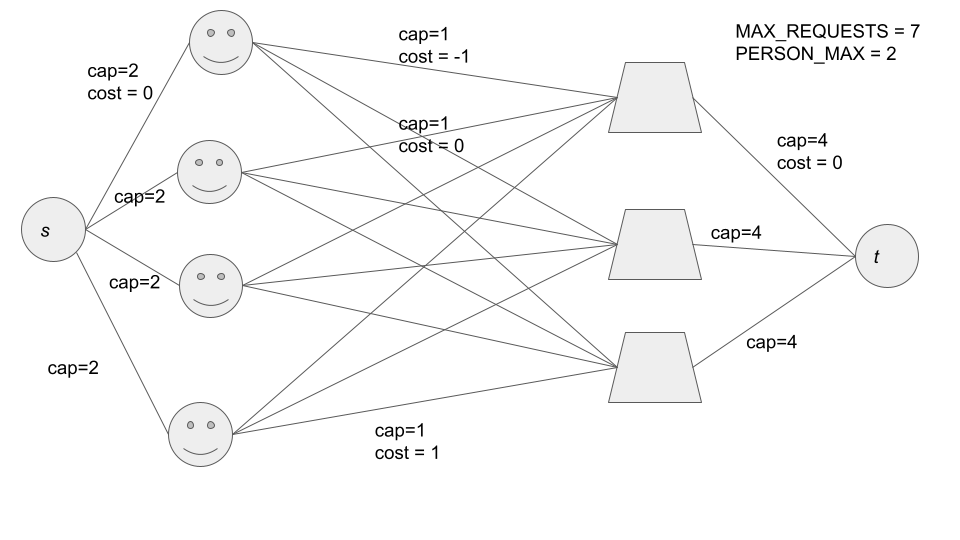

In [2]:
Image(filename='dummygraph.png')

In [3]:
in_file = 'generated_data.tsv' # tsv of people with onboardID and companies
out_file = 'matches.tsv'       # tsv of matches generated, onboardID, company1, company2

#manual_match_file = 'handmatches.tsv' # use if you have pre-assigned match data to include
manual_match_file = False          #use if you don't have any pre-assigned matches to read in

## Read in people file
Should have an onboardID and columns of companies.

In [4]:
people = pd.read_csv(in_file, delimiter="\t", index_col='onboardID')
people.sample(5)

,acxiom,ancestry,beenverified,clubhouse,infinitemediaconcepts,intel,mcdonalds,mediaocean,mylife,name,...,quora,target,tesla,thomsonreuters,tmobile,twitter,uber,walgreens,walmart,xfinity
onboardID,,,,,,,,,,,,,,,,,,,,,
641,0,0,0,1,0,0,0,0,0,Reno,...,1,0,0,0,1,1,1,0,0,0
785,0,0,0,0,0,0,0,0,0,Florentino,...,0,0,0,0,0,1,0,0,0,0
661,0,0,1,0,1,0,0,0,0,Lamar,...,0,0,1,0,0,0,0,1,1,0
854,0,1,0,0,0,0,0,0,0,Beryl,...,0,1,0,0,1,1,0,1,1,0
559,1,0,0,1,0,0,0,0,0,Lizeth,...,0,0,0,0,0,1,0,0,1,1


## Types of companies

In [5]:
company_type_dict = {
'acxiom':'broker',
'ancestry' :'consumer',
'beenverified': 'broker',
'clubhouse' : 'social',
'infinitemediaconcepts':'broker',
'intel': 'broker',
'mcdonalds' :'consumer',
'mediaocean': 'broker',
'mylife': 'broker',
'neustar' : 'broker',
'oracle' : 'broker',
'quora' : 'social',
'target' : 'consumer',
'tesla' : 'consumer',
'thomsonreuters':'broker',
'tmobile' : 'telco',
'twitter' : 'social',  
'uber': 'consumer',
'walgreens':'consumer',
'walmart':	'consumer',
'xfinity':	'telco',    
}

In [6]:
companies = company_type_dict.copy()

## Find the rarest comapnies

In [7]:
# Find the rarest companies.
rare_companies = people[list(companies.keys())].sum().sort_values()
rare_companies

beenverified              2
mediaocean                2
mylife                    2
neustar                   2
infinitemediaconcepts     3
tesla                     5
acxiom                    6
thomsonreuters            6
intel                     8
clubhouse                12
oracle                   13
mcdonalds                13
xfinity                  13
ancestry                 15
quora                    22
target                   25
walmart                  25
walgreens                27
tmobile                  33
uber                     33
twitter                  39
dtype: int64

### If less than 10% of people have an account, call it a rare company

In [8]:
# utility function
def isRare(company, numPeople=len(people.index)):
    return rare_companies[company] <= math.ceil(numPeople*.1)

### Make an empty matching matrix

In [9]:
match_matrix = people[list(companies.keys())].copy()
match_matrix = match_matrix.replace(match_matrix, 0)

## Network Flow Approach
Model this matching problem as a network flow problem with costs and capacity. The goal is to match up the most nodes with at the least cost. 

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.max_flow_min_cost.html#networkx.algorithms.flow.max_flow_min_cost

In [10]:
g = nx.DiGraph()
nodes_people = list(people.index)
nodes_company = companies.keys()

# Define the maxes we're willing to send
MAX_REQUESTS = 200
PERSON_MAX = 2
COMPANY_MAX = math.ceil(len(nodes_people)*PERSON_MAX / len(nodes_company))
COMPANY_MAX

10

In [11]:
# The matrix that shows which people have accounts where
account_matrix = people[list(nodes_company)]

### Build nodes

In [12]:
# Build a directed graph with People nodes, Company nodes, a source, and a sink
g.add_nodes_from(nodes_people)
g.add_nodes_from(nodes_company)
g.add_node('s') # source node
g.add_node('t') # sink node

### Build the edges between nodes
Edges have a capacity and a cost. The cost is how 'expensive' it is to match a person to a company. 

Since we want more people to be matched with companies they have accounts with, we'll make those edges cheaper. If they don't have an account, the edge will be more expensive.

Edges with data brokers are free (cost=0), since no one has accounts with them anyway.
Edges with rare accounts give you a refund (cost=-1) since we want to incentivize those matches more.

(aside for another day: there is probably a better way to do this by incorporating a demand model as well.)

In [13]:
# Connect source and sink
for person, row in account_matrix.iterrows():
    g.add_edge('s', person, capacity=PERSON_MAX) #connect source to people
    
    for company, hasAccount in row.items():
        g.add_edge(company, 't', capacity = COMPANY_MAX, cost=0) #connect company to sink
        cost = 0
        
        # Connect people to companies
        if hasAccount:
            if isRare(company, len(nodes_people)):
                cost = -1
            else:
                cost = 1            
        elif company_type_dict[company] == 'broker':
            # no one is gonna have an account w data brokers, so don't punish them
            cost = 0
        else:
            # avoid pairing people who don't have accounts
            cost = 1 
        g.add_edge(person, company, capacity=1, weight=cost)

### Find matches!
That is, calculate the maximum total flow at the least cost.

In [14]:
matches = nx.algorithms.flow.max_flow_min_cost(g, 's', 't', capacity='capacity', weight='weight')

In [15]:
# calculate the cost just as FYIs/sanity check. Should be close to 0.
# Negative means there's more matches-with-account than matches-without-account
nx.algorithms.flow.cost_of_flow(g, matches) 

70

### Build the Person-Company match matrix
The flow algorithms spit out residual graph dictionaries, which are a pain to work with. Convert this to a nice dataframe instead.

1 means match. 0 means no match.

In [16]:
match_matrix = people[list(nodes_company)].copy()
match_matrix = match_matrix.replace(match_matrix, 0)


for company in nodes_company:
    for oid in nodes_people:
        match_matrix.at[oid, company] = matches[oid][company]
        
match_matrix.head()

,acxiom,ancestry,beenverified,clubhouse,infinitemediaconcepts,intel,mcdonalds,mediaocean,mylife,neustar,...,quora,target,tesla,thomsonreuters,tmobile,twitter,uber,walgreens,walmart,xfinity
onboardID,,,,,,,,,,,,,,,,,,,,,
968,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
676,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
131,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
723,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## How good was our matching?

In [17]:
matched_accounts = match_matrix & account_matrix 
matched_noaccount = match_matrix &  (match_matrix ^ account_matrix)

frame = {"w account" : matched_accounts.sum(),
         "w/out account" : matched_noaccount.sum(),
         "total": matched_accounts.sum() + matched_noaccount.sum()
        }

match_totals = pd.DataFrame(frame['total']).astype(int)
match_totals = match_totals.rename(columns={0:"total DARs"})

display("Total Matches by Company")
pd.DataFrame(frame).sort_values(by=["total", "w/out account", "w account"])

'Total Matches by Company'

,total,w account,w/out account
uber,6,2,4
walmart,7,2,5
tesla,9,5,4
walgreens,9,2,7
target,9,1,8
intel,10,8,2
acxiom,10,6,4
thomsonreuters,10,6,4
twitter,10,4,6
ancestry,10,3,7


In [18]:
# Example for if you want to see who is assigned to Intel
#account_matrix['intel'] ==1

# Example for if you want to see what companies a person is assigned to
#account_matrix.loc[56] == 1

# Example for if you want to manually rebalance. e.g., switch 55 from neustar to quora
#match_matrix.at[55, "neustar"]=0
#match_matrix.at[55, "quora"]=1

## Summarize

In [19]:
print("Number of people:", len(people.index))
print("Numer of companies: ", len(companies))
print("DARs/company: ")
match_totals.apply([min, max, pd.DataFrame.median, sum]).astype(int)

Number of people: 100
Numer of companies:  21
DARs/company: 


,total DARs
min,6
max,10
median,10
sum,200


## Put the matches in a handy format for exporting

In [20]:
export_matches = pd.DataFrame(index = nodes_people, columns=["company1", "company2"])
export_matches.index = export_matches.index.rename('onboardID')
for person in nodes_people:
    cos = [company for company, isMatched in match_matrix.loc[person].to_dict().items() if isMatched]
    export_matches.at[person, 'company1'] = cos[0]
    export_matches.at[person, 'company2'] = cos[1]
    
export_matches.sample(4)

,company1,company2
onboardID,,
858,target,uber
46,twitter,xfinity
113,ancestry,mylife
193,beenverified,mediaocean


In [21]:
export_matches.to_csv(out_file, sep='\t')